In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'latent variable')

<Figure size 864x432 with 0 Axes>

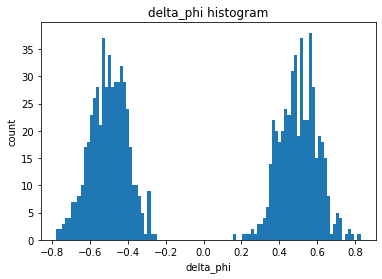

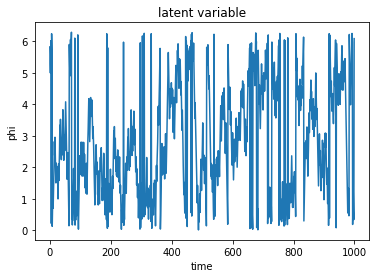

In [ ]:
#set up parameters and create latent circular variable (phi)

n_time_points = 1000
n_cells = 10000

plt.figure(figsize=(12,6))
delta_phi = (np.random.randn(n_time_points)/5 + 1) * ((np.random.random(n_time_points) < 0.5) - .5) 
latent_phi = np.cumsum(delta_phi)[None,:]

plt.figure()
plt.title('delta_phi histogram')
plt.hist(delta_phi,100);
plt.xlabel('delta_phi')
plt.ylabel('count')

plt.figure()
plt.plot(latent_phi.T % (2*np.pi))
plt.xlabel('time')
plt.ylabel('phi')
plt.title('latent variable')

In [ ]:
#create on-ring cells with random phase tuning preference

ring_fraction = 0.1
n_on_ring = int(n_cells * ring_fraction)
#now assign latent variable to fist n_on_ring cells, then assign private random latent variables to each of the rest of cells (wanted individual activity statistics to be the same for all cells)
phi_all = np.tile(latent_phi, (n_cells,1))
phi_all[n_on_ring:, :] = np.cumsum((np.random.randn(n_cells - n_on_ring, n_time_points)/5 + 1) * ((np.random.random(size=(n_cells - n_on_ring, n_time_points)) < 0.5) - .5) , axis=1)

Text(0, 0.5, 'cell')

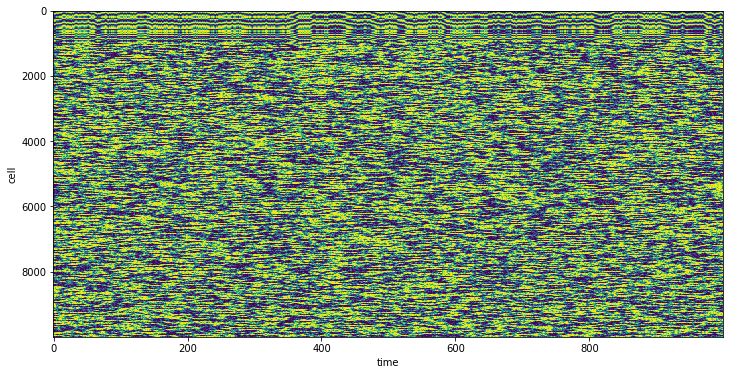

In [ ]:
best_phi = np.random.rand(n_cells) * 2 * np.pi
activity = np.cos(best_phi[:,None] - phi_all) 
plt.figure(figsize=(12,6))
plt.imshow(activity, aspect='auto', interpolation='nearest')
plt.xlabel('time')
plt.ylabel('cell')

Text(0, 0.5, 'activity')

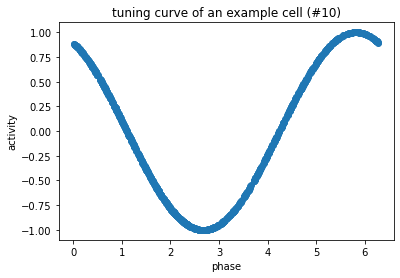

In [ ]:
# check tuning of example cell

cell_id = 10
plt.scatter(latent_phi%(2*np.pi), activity[cell_id,:])
plt.title(f'tuning curve of an example cell (#{cell_id})')
plt.xlabel('phase')
plt.ylabel('activity')

In [ ]:
# reduce dimentionality of activity data with PCA (reduce along cells dimension)

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
activity_pca = pca.fit_transform(activity.T).T
#da = np.diff(activity_pca, axis=1)

In [ ]:
# fast jPCA implementation

def lstsq_skew(A, B):
    # find least squares solution to AX = B, with X being a skew-symmetric matrix
    # see https://amcaonline.org.ar/ojs/index.php/mc/article/viewFile/774/731
    P,s,Qt = np.linalg.svd(A, full_matrices=False)
    C = (P.T @ B @ Qt.T)
    Y = (C*s[:,None] - C.T*s[None, :]) / (s[:,None]**2 + s[None, :]**2)
    X = Qt.T @ Y @ Qt
    return X

def jpca(A, weights=1):
    # weighted jPCA
    dA = A[:,1:] - A[:,:-1]
    M_skew = lstsq_skew((A[:,:-1] + A[:,1:])/2, dA*weights)
    w, jpc = np.linalg.eig(M_skew)
    return jpc[:,::2]

def jpca_tails(F_before, F_after, weights):
    dA = F_after - F_before
    F0 = F_before * (weights>=0) + F_after * (weights<0)
    # F0 = (F_before + F_after) / 2 # you can also try this instead
    M_skew = lstsq_skew(F0, dA*weights)
    w, jpc = np.linalg.eig(M_skew)
    return jpc[:,::2]

In [ ]:
def lstsq_skew_hacked(A, B):
    # first solving the unconstrained equation, then making the result skew (I don't think this works)
    X = np.linalg.pinv(A) @ B
    return (X - X.T)/2

In [ ]:
# # "standard" jpca
# jpc = jpca(activity_pca)

In [ ]:
# # weighted jpca (dA weighted by known stimulus sign only)
# jpc = jpca(activity_pca, weights=np.sign(delta_phi[1:]))

In [ ]:
# weighted jpca (dA weighted by known stimulus sign and amplitude)
jpc = jpca(activity_pca, weights=1/delta_phi[1:])

Text(0, 0.5, 'weight')

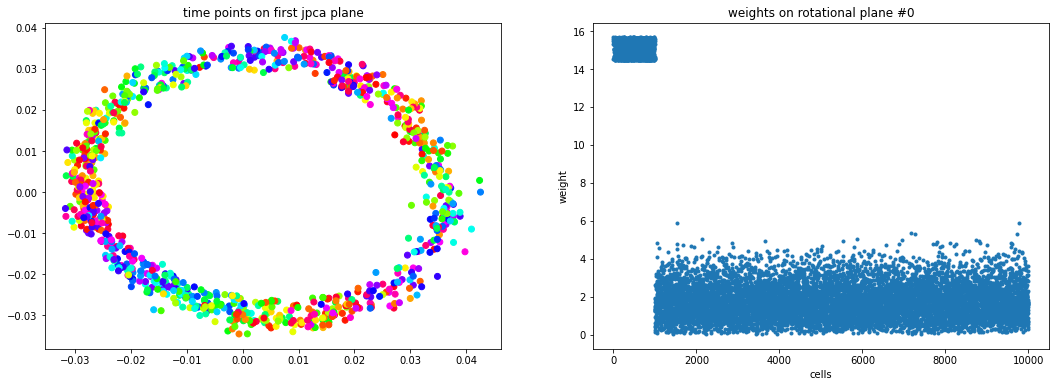

In [ ]:
# inspect jpc result
plane_id = 0

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].scatter(jpc.real[:,plane_id], jpc.imag[:,plane_id], c=latent_phi[:,1:] % 2*np.pi, cmap='hsv')
ax[0].set_title('time points on first jpca plane')

weights = np.abs((activity[:,1:] @ jpc[:, plane_id]))
ax[1].plot(weights, '.')
ax[1].set_title(f'weights on rotational plane #{plane_id}')
ax[1].set_xlabel('cells')
ax[1].set_ylabel('weight')

In [ ]:
# # "hacked" weighted jpca (solving for M, then calculating M_skew)
# ma = (activity_pca[:,1:] + activity_pca[:,:-1])/2
# da = (activity_pca[:,1:] - activity_pca[:,:-1])
# M = ma.T @ np.linalg.pinv(da.T / delta_phi[1:,None])
# M_skew = (M - M.T)/2
# w, jpc = np.linalg.eig(M_skew)
# jpc = jpc[:,::2]